### Fine-tuning mt5 for cleaning italian ocr text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
#from transformers import T5Tokenizer, MT5ForConditionalGeneration
from tqdm.notebook import tqdm 
import evaluate
import numpy as np
from datasets import load_from_disk
import seaborn as sns

2025-08-18 14:16:14.926913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load datasets

In [2]:
train = load_from_disk("../datasets/t5-datasets/train")
# shuffle the dataset
train = train.shuffle(seed=42)

# We reserve a 8% of the training set for evaluation
train = train.train_test_split(test_size=0.08)

In [3]:
train_dataset = train['train']
eval_dataset = train['test']

#### Load mt5-small and its tokenizer

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained("../../mt5-small")
tokenizer = AutoTokenizer.from_pretrained("../../mt5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/gjergj/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Preparing the data for fine-tuning

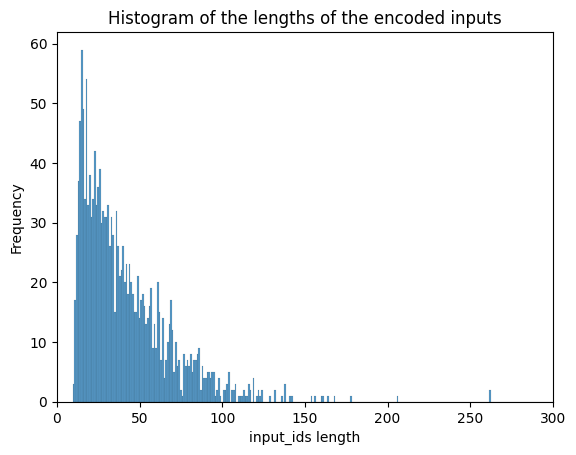

In [6]:
encoded_inputs_length = [] # store the length of the encoded samples

for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')
    encoded_inputs_length.append(len(input_ids[0]))

encoded_inputs_length.sort(reverse=True)

sns.histplot(encoded_inputs_length, bins=10, discrete=True)

plt.xlim(0, 300)
plt.xlabel('input_ids length')
plt.ylabel('Frequency')
plt.title('Histogram of the lengths of the encoded inputs')

plt.show()

In [ ]:
# As we can see from the plot, the length of the encoded inputs is concentrated in the range 
# from 0 to 50. Since setting a high value fro the input length is computationally expensive 
# we keep it for now equal to 35

max_input_length = model.config.max_length          # which is 20 by default
max_target_length = model.config.max_length

In [8]:
def encode_str(text, tokenizer, seq_len):
    ''' 
    We define a function that tokenizes each sample, pads it to a certain max length, 
    and truncates samples that exeed such max length
    '''
    input_ids = tokenizer.encode(
        text=text,
        return_tensors = 'pt', 
        padding = 'max_length', 
        truncation = True, 
        max_length = seq_len
    )

    return input_ids[0]

In [9]:
print(train['train'][0])

{'ocr': " \nAllora  grandi  risate  daccapo  :  ma  l' omino,  in- \n\n\nvece  di  ridere,  si  sentì  preso  da  tanto  amore  per \nqueir  irrequieto  asinelio  che,  con  un  bacio,  gli \nportò  via  di  netto  là  metà  di  quell'altro  orec- \nchio.", 'clean': 'Allora grandi risate daccapo: ma l’omino, invecedi ridere, si sentì preso da tanto amore per quell’irrequieto asinello che, con un bacio, gli portò via di netto la metà di quell’altro orecchio.'}


In [10]:
t1 = encode_str(train['train'][0]['ocr'], tokenizer, max_input_length)
print(f'Encoded sample: \n {t1} \n length: {len(t1)}')

# Let's print the actual tokens
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

Encoded sample: 
 tensor([   298, 100835,  30864, 103629,    346,    350,  15346,   1331,    259,
           267,    496,    259,    280,    277,    542,   3877,    261,    281,
           264,      1]) 
 length: 20
['▁A', 'llora', '▁grandi', '▁risa', 'te', '▁da', 'cca', 'po', '▁', ':', '▁ma', '▁', 'l', "'", '▁om', 'ino', ',', '▁in', '-', '</s>']


In [11]:
''' 
Now we want a function that encodes the input_text and the target_text, 
so here we are going to encode the ocr sample and the corresponding cleaned sample
'''

def encode_sample(sample, tokenizer, seq_input_len, seq_target_len):
    ''' 
    sample: ['ocr', 'clean']
    '''
    ocr = sample['ocr']
    clean = sample['clean']

    if ocr is None or clean is None:
        return None 
    
    input_token_ids = encode_str(ocr, tokenizer, seq_input_len)
    target_token_ids = encode_str(clean, tokenizer, seq_target_len)

    return input_token_ids, target_token_ids

In [12]:
''' 
Now we define a function to encode batches of samples 
'''

def encode_batch(batch, tokenizer):
    inputs = []
    targets = []

    '''
    - batch: dictionary of the for {'ocr': [list of ocr samples],
                                    'clean': [list of the corresponding clean samples]} 
    - tokenizer: mt5 tokenizer
    '''

    ocr_samples = batch['ocr']
    clean_samples = batch['clean']
    for i in range(len(ocr_samples)):
        sample = {}
        sample['ocr'] = ocr_samples[i]
        sample['clean'] = clean_samples[i]
        
        formatted_data = encode_sample(sample, tokenizer, max_input_length, max_target_length)

        if formatted_data == None:
            continue

        input_ids, target_ids = formatted_data

        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))

    batch_input_ids = torch.cat(inputs)
    batch_target_ids = torch.cat(targets)

    return batch_input_ids, batch_target_ids

In [13]:
''' 
function to create a generator object to generate batches of data
'''
def data_generator(dataset, tokenizer, batch_size):

    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size] 
        yield encode_batch(raw_batch, tokenizer)


In [13]:
raw_batch = train_dataset[0: 16]
ocr_samples = raw_batch['ocr']
clean_samples = raw_batch['clean']
for i in range(len(ocr_samples)):
    sample = {}
    sample['ocr'] = ocr_samples[i]
    sample['clean'] = clean_samples[i]

    print(sample)

{'ocr': '  !  Vieni  qua \nda  me,  e  dammi  un  bacio.', 'clean': 'Vieni qua da me e dammi un bacio.'}
{'ocr': " \nAlla  fine,  e  per  sua  buona  fortuna,  venne  un'on- \ndata tanto  prepotente  e  impetuosa,  che  lo  scara- \nventò di  peso  sulla  rena  del  lido.", 'clean': 'Alla fine, e per sua buona fortuna, venne un’ondata tanto prepotente e impetuosa, che lo scaraventò di peso sulla rena del lido.'}
{'ocr': ' \n—  Così  non  lo  posso  bere!  —  disse  il  burat- \ntino, facendo  mille  smorfie.', 'clean': '— Così non lo posso bere!— disse il burattino, facendo mille smorfie.'}
{'ocr': ' \nI  carabinieri,  giudicando  che  fosse  difficile  rag- \ngiungerlo, gli  aizzarono  dietro  un  grosso  cane \nmastino  che  aveva  guadagnato  il  inumo  i)remio \na  tutte  le  corse  dei  cani.', 'clean': 'I carabinieri, giudicando che fosse difficile raggiungerlo, gli aizzarono dietro un grosso cane mastino che aveva guadagnato il primo premio a tutte le corse dei cani.'}
{'ocr': "

In [14]:
data_gen = data_generator(train_dataset, tokenizer, batch_size=8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

Input shape: torch.Size([8, 20])
Output shape: torch.Size([8, 20])


### Training 

In [24]:
# training hyperparameters
n_epochs = 3
batch_size = 8
eval_batch_size = 4
print_freq = 25 
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01)

In [25]:
print(f'Total Steps: {total_steps}')
print(f'Warmup Steps: {n_warmup_steps}')

Total Steps: 624
Warmup Steps: 6


In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# We define a scheduler that will take care of adapting the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

In [18]:
train_loss = []
eval_losses = []

**Evaluation function**

In [ ]:
def eval_model(model, dataset):
    eval_data = data_generator(dataset, tokenizer, eval_batch_size)

    eval_losses = []
    for _, (input_batch, label_batch) in enumerate(eval_data):
        
        # forward pass
        with torch.no_grad()
            model_out = model.forward(input_ids=input_batch, 
                                    labels=label_batch)
        
        eval_losses.append(model_out.loss.item())

    
    return np.mean(eval_losses)



**Training framework**

In [20]:
for epoch_idx in range(n_epochs):
    data = data_generator(train_dataset, tokenizer, batch_size)

    for batch_idx, (input_batch, label_batch) in tqdm(enumerate(data), total=n_batches):

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        model_out = model.forward(
            input_ids = input_batch, 
            labels = label_batch    # not strictly necessarily, but if we do it,
                                    # it computes the loss for us
        )

        loss = model_out.loss
        train_loss.append(loss.item())

        # compute the gradients
        loss.backward()

        # update the weights
        optimizer.step()

        # The scheduler adaptes the leraning rate
        scheduler.step()

        if (batch_idx + 1) % print_freq == 0:
            #average loss for the last 'print_freq' batches
            avg_loss = np.mean(train_loss[-print_freq:])
            eval_loss = eval_model(model, eval_dataset)
            eval_losses.append(eval_loss)
            print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
                epoch_idx+1, batch_idx+1, avg_loss, eval_loss, scheduler.get_last_lr()[0]))

torch.save(model.state_dict(), '../model/new_mt5_finetuned')



  0%|          | 0/208 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 25 | Avg. train loss: 21.310 | Avg. val loss: 14.493 | lr: 0.0004927184466019418
Epoch: 1 | Step: 50 | Avg. train loss: 8.966 | Avg. val loss: 5.665 | lr: 0.0004805825242718447
Epoch: 1 | Step: 75 | Avg. train loss: 4.224 | Avg. val loss: 3.748 | lr: 0.0004684466019417476
Epoch: 1 | Step: 100 | Avg. train loss: 3.248 | Avg. val loss: 3.044 | lr: 0.0004563106796116505
Epoch: 1 | Step: 125 | Avg. train loss: 2.712 | Avg. val loss: 2.482 | lr: 0.0004441747572815534
Epoch: 1 | Step: 150 | Avg. train loss: 2.184 | Avg. val loss: 2.164 | lr: 0.00043203883495145627
Epoch: 1 | Step: 175 | Avg. train loss: 1.957 | Avg. val loss: 1.886 | lr: 0.0004199029126213592
Epoch: 1 | Step: 200 | Avg. train loss: 1.738 | Avg. val loss: 1.658 | lr: 0.00040776699029126213


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch: 2 | Step: 25 | Avg. train loss: 1.351 | Avg. val loss: 1.405 | lr: 0.00039174757281553395
Epoch: 2 | Step: 50 | Avg. train loss: 1.145 | Avg. val loss: 1.331 | lr: 0.0003796116504854369
Epoch: 2 | Step: 75 | Avg. train loss: 1.064 | Avg. val loss: 1.244 | lr: 0.0003674757281553398
Epoch: 2 | Step: 100 | Avg. train loss: 1.059 | Avg. val loss: 1.182 | lr: 0.0003553398058252427
Epoch: 2 | Step: 125 | Avg. train loss: 0.974 | Avg. val loss: 1.133 | lr: 0.00034320388349514563
Epoch: 2 | Step: 150 | Avg. train loss: 0.953 | Avg. val loss: 1.104 | lr: 0.00033106796116504853
Epoch: 2 | Step: 175 | Avg. train loss: 0.845 | Avg. val loss: 1.054 | lr: 0.0003189320388349515
Epoch: 2 | Step: 200 | Avg. train loss: 0.879 | Avg. val loss: 1.054 | lr: 0.0003067961165048544


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch: 3 | Step: 25 | Avg. train loss: 0.716 | Avg. val loss: 1.010 | lr: 0.0002907766990291262
Epoch: 3 | Step: 50 | Avg. train loss: 0.674 | Avg. val loss: 1.008 | lr: 0.0002786407766990292
Epoch: 3 | Step: 75 | Avg. train loss: 0.694 | Avg. val loss: 1.010 | lr: 0.0002665048543689321
Epoch: 3 | Step: 100 | Avg. train loss: 0.737 | Avg. val loss: 0.997 | lr: 0.00025436893203883493
Epoch: 3 | Step: 125 | Avg. train loss: 0.696 | Avg. val loss: 0.975 | lr: 0.00024223300970873787
Epoch: 3 | Step: 150 | Avg. train loss: 0.684 | Avg. val loss: 0.977 | lr: 0.00023009708737864077
Epoch: 3 | Step: 175 | Avg. train loss: 0.606 | Avg. val loss: 0.961 | lr: 0.00021796116504854368
Epoch: 3 | Step: 200 | Avg. train loss: 0.620 | Avg. val loss: 0.966 | lr: 0.0002058252427184466


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch: 4 | Step: 25 | Avg. train loss: 0.514 | Avg. val loss: 0.959 | lr: 0.00018980582524271846
Epoch: 4 | Step: 50 | Avg. train loss: 0.502 | Avg. val loss: 0.979 | lr: 0.00017766990291262136
Epoch: 4 | Step: 75 | Avg. train loss: 0.494 | Avg. val loss: 0.970 | lr: 0.00016553398058252427
Epoch: 4 | Step: 100 | Avg. train loss: 0.562 | Avg. val loss: 0.956 | lr: 0.0001533980582524272
Epoch: 4 | Step: 125 | Avg. train loss: 0.518 | Avg. val loss: 0.953 | lr: 0.00014126213592233008
Epoch: 4 | Step: 150 | Avg. train loss: 0.511 | Avg. val loss: 0.960 | lr: 0.000129126213592233
Epoch: 4 | Step: 175 | Avg. train loss: 0.455 | Avg. val loss: 1.001 | lr: 0.00011699029126213593
Epoch: 4 | Step: 200 | Avg. train loss: 0.463 | Avg. val loss: 1.005 | lr: 0.00010485436893203885


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch: 5 | Step: 25 | Avg. train loss: 0.366 | Avg. val loss: 1.003 | lr: 8.883495145631068e-05
Epoch: 5 | Step: 50 | Avg. train loss: 0.371 | Avg. val loss: 0.982 | lr: 7.66990291262136e-05
Epoch: 5 | Step: 75 | Avg. train loss: 0.372 | Avg. val loss: 1.006 | lr: 6.45631067961165e-05
Epoch: 5 | Step: 100 | Avg. train loss: 0.418 | Avg. val loss: 0.990 | lr: 5.242718446601942e-05
Epoch: 5 | Step: 125 | Avg. train loss: 0.398 | Avg. val loss: 0.985 | lr: 4.029126213592233e-05
Epoch: 5 | Step: 150 | Avg. train loss: 0.393 | Avg. val loss: 0.990 | lr: 2.8155339805825243e-05
Epoch: 5 | Step: 175 | Avg. train loss: 0.339 | Avg. val loss: 1.026 | lr: 1.6019417475728155e-05
Epoch: 5 | Step: 200 | Avg. train loss: 0.348 | Avg. val loss: 1.038 | lr: 3.883495145631068e-06


#### Plots

In [21]:
def plot(data, label):
    plt.plot(data, label=label)
    plt.legend()
    plt.show()

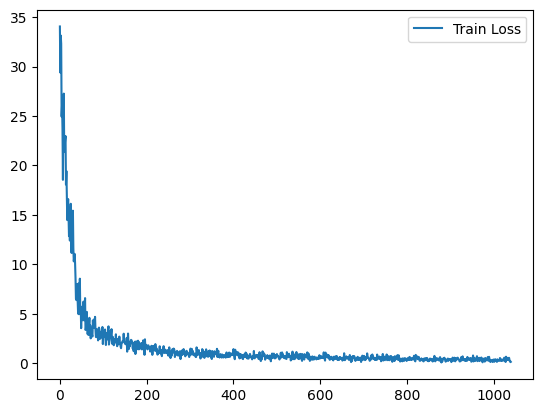

In [ ]:
plot(train_loss, label='Train loss')

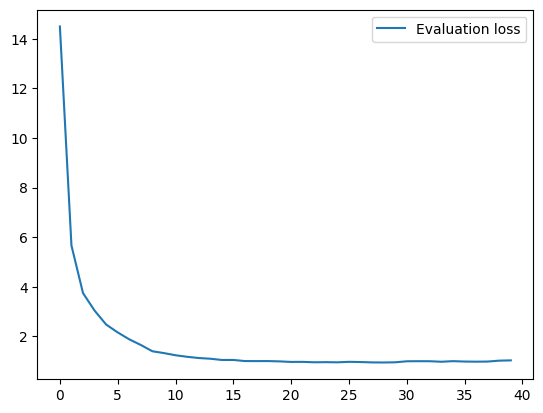

In [23]:
plot(eval_losses, label='Evaluation loss')

#### Testing and Inference

In [26]:
# Load the test dataset
test = load_from_disk("../datasets/t5-datasets/test")

In [59]:
ocr_sample = test[65]['ocr']
clean_sample = test[65]['clean']

In [60]:
print(f'ocr_sample:\n{ocr_sample}\n')
print(f'clean_sample:\n{clean_sample}')

ocr_sample:
 
—  Io  non  ve  1'  ho  tirato  ! 
—  Bugiardo!

clean_sample:
— Io non ve l’ho tirato!— Bugiardo!


In [68]:
input_ids = encode_str(ocr_sample, tokenizer, max_input_length)
input_ids = input_ids.unsqueeze(0)

output_tokens = model.generate(input_ids, num_beams=1, num_return_sequences=1)
prediction = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(prediction)

— Io non ve non ho tirato!— Bugiardo!


In [62]:
for token_set in output_tokens:
    prediction = tokenizer.decode(token_set,skip_special_tokens=True)

    print(prediction)

— Io non ve non ho tirato!— Bugiardo!


#### Rouge scores

In [63]:
metric = evaluate.load("rouge")

In [84]:
def compute_rouge(dataset, model):
    '''
    - dataset: test dataset 
    '''

    model.eval()

    test_data = data_generator(dataset, tokenizer, batch_size=4)

    all_decoded_preds = []
    all_decoded_labels = []

    #test_losses = []
    for _, (input_batch, label_batch) in enumerate(test_data):
        preds = model.generate(input_batch, num_beams=1, num_return_sequences=1)
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(label_batch, skip_special_tokens=True)

        all_decoded_preds.extend(decoded_preds)
        all_decoded_labels.extend(decoded_labels)

    result = metric.compute(predictions=all_decoded_preds, references=all_decoded_labels)

    return result
    


In [85]:
rouge_scores = compute_rouge(test, model)

In [86]:
print(rouge_scores)

{'rouge1': 0.7774912485382005, 'rouge2': 0.69925788533276, 'rougeL': 0.7726068291210269, 'rougeLsum': 0.7731892934093172}
